Generating Synthetic Critical Attention Matrix...
Analyzing RG Flow for Matrix shape: torch.Size([4096, 4096])
RG Analysis Complete. Plot saved to 'rg_flow_experiment.png'.


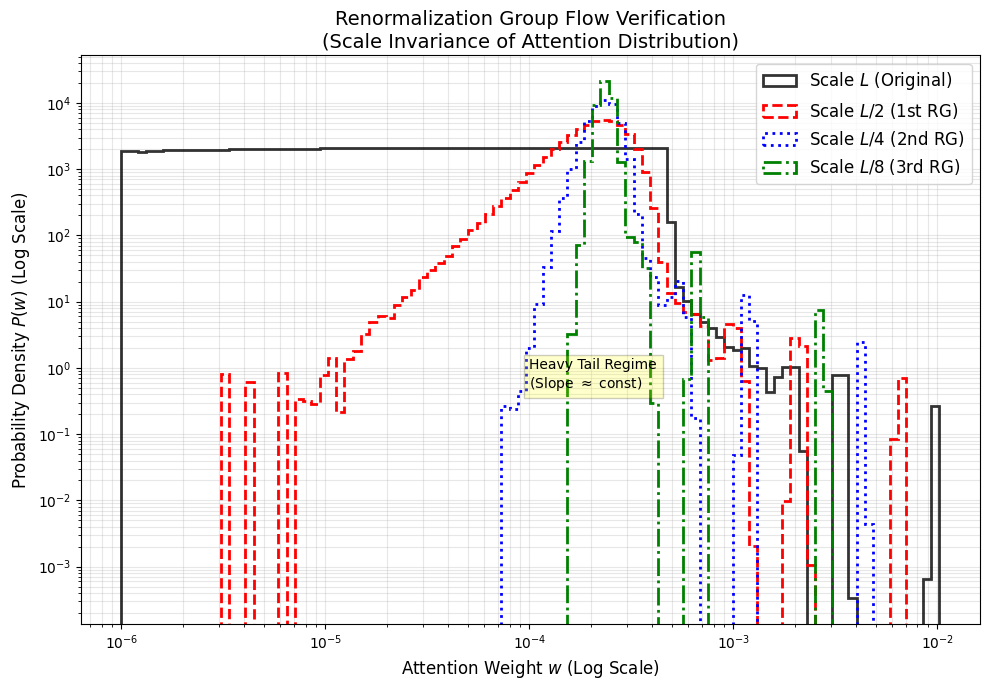

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def generate_synthetic_fractal_attention(seq_len=2048, hurst=0.8):
    """
    生成一个合成的、具有分形特征的注意力矩阵用于测试。
    模拟理想的临界状态：A_ij ~ 1 / |i-j|^(2H)
    """
    # 1. 创建距离矩阵 dist[i, j] = |i - j|
    x = torch.arange(seq_len).float()
    dist_matrix = torch.abs(x.unsqueeze(0) - x.unsqueeze(1))
    
    # 2. 避免除以零
    dist_matrix = dist_matrix + 1.0 
    
    # 3. 生成幂律衰减 (Fractal Structure)
    # 理论预测: Attention ~ Distance^(-2H)
    # 添加一些随机噪声模拟真实训练中的波动
    noise = torch.rand(seq_len, seq_len) * 0.05
    # 核心公式：分数布朗运动的导数（噪声）相关性
    raw_scores = 1.0 / (dist_matrix.pow(hurst * 2)) + noise
    
    # 4. 归一化 (模拟 Softmax 后的概率分布)
    # 保持物理意义：每一行的和为 1
    attn_matrix = raw_scores / raw_scores.sum(dim=-1, keepdim=True)
    
    return attn_matrix

def check_rg_invariance(attn_matrix):
    """
    执行重整化群 (RG) 变换并检查分布的尺度不变性。
    """
    print(f"Analyzing RG Flow for Matrix shape: {attn_matrix.shape}")
    
    # 准备数据：PyTorch 池化需要 [Batch, Channel, Height, Width] 格式
    # 原始矩阵 (Scale L)
    A_0 = attn_matrix.unsqueeze(0).unsqueeze(0)
    
    # --- RG 步骤 1: 第一次粗粒化 (2x2 Block Spin) ---
    # 物理意义：将 4 个微观状态合并为 1 个宏观状态 (Block Spin Transformation)
    # 使用 Average Pooling 模拟重整化的“平滑”过程
    A_1 = F.avg_pool2d(A_0, kernel_size=2)
    
    # --- RG 步骤 2: 第二次粗粒化 (L/4) ---
    A_2 = F.avg_pool2d(A_1, kernel_size=2)
    
    # --- RG 步骤 3: 第三次粗粒化 (L/8) ---
    A_3 = F.avg_pool2d(A_2, kernel_size=2)

    # 提取数值用于绘图
    # 过滤掉极小值以避免 Log-Log 图上的数值错误
    def get_data(tensor):
        d = tensor.flatten().detach().cpu().numpy()
        return d[d > 1e-9] # 过滤掉数值不稳定的极小项

    w_0 = get_data(A_0)
    w_1 = get_data(A_1)
    w_2 = get_data(A_2)
    w_3 = get_data(A_3)

    # --- 绘图 ---
    plt.figure(figsize=(10, 7))
    
    # 设置 Log-Log 直方图的箱体 (Log-spaced bins)
    # 这种分箱方式对于观察幂律分布至关重要
    bins = np.logspace(np.log10(1e-6), np.log10(np.max(w_0)), 100)
    
    # 绘制直方图 (step 风格，线条更清晰)
    # density=True 保证面积为1，使得不同尺度的分布可以比较
    plt.hist(w_0, bins=bins, density=True, histtype='step', label='Scale $L$ (Original)', linewidth=2, color='black', alpha=0.8)
    plt.hist(w_1, bins=bins, density=True, histtype='step', label='Scale $L/2$ (1st RG)', linewidth=2, color='red', linestyle='--')
    plt.hist(w_2, bins=bins, density=True, histtype='step', label='Scale $L/4$ (2nd RG)', linewidth=2, color='blue', linestyle=':')
    plt.hist(w_3, bins=bins, density=True, histtype='step', label='Scale $L/8$ (3rd RG)', linewidth=2, color='green', linestyle='-.')

    plt.xscale('log')
    plt.yscale('log')
    
    plt.title('Renormalization Group Flow Verification\n(Scale Invariance of Attention Distribution)', fontsize=14)
    plt.xlabel('Attention Weight $w$ (Log Scale)', fontsize=12)
    plt.ylabel('Probability Density $P(w)$ (Log Scale)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, which="both", alpha=0.3)
    
    # 标注理论意义
    plt.text(1e-4, 0.5, "Heavy Tail Regime\n(Slope $\\approx$ const)", fontsize=10, bbox=dict(facecolor='yellow', alpha=0.2))
    
    plt.tight_layout()
    plt.savefig('rg_flow_experiment.png')
    print("RG Analysis Complete. Plot saved to 'rg_flow_experiment.png'.")
    plt.show()

if __name__ == "__main__":
    # 1. 模拟生成一个处于临界状态的注意力矩阵
    # Hurst 指数 H=0.8 代表强烈的长程相关 (Long-range dependence)
    print("Generating Synthetic Critical Attention Matrix...")
    fractal_attn = generate_synthetic_fractal_attention(seq_len=4096, hurst=0.8)
    
    # 2. 执行 RG Flow 验证
    check_rg_invariance(fractal_attn)